In [2]:
import tensorflow as tf
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
from IPython.display import SVG

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
%matplotlib inline

from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
import keras.optimizers
from sklearn.metrics import classification_report
import keras.optimizers
from keras.applications import vgg16
import numpy as np
import random
import os
from tqdm import tqdm
import pickle
import cv2

2024-02-01 01:40:12.476232: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-01 01:40:12.492444: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-01 01:40:12.593262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 01:40:12.593326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 01:40:12.614005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

#ِDataset

In [3]:
# Define necessary constants
# TEST_DIR = '/content/drive/MyDrive/brain_dataset/test'
# TRAIN_DIR = '/content/drive/MyDrive/brain_dataset/train'
TEST_DIR = 'brain_dataset/test'
TRAIN_DIR = 'brain_dataset/train'
IMG_SIZE = 224
CATEGORIES = ["yes","no"]

#Data Preprocessing

In [4]:
def crop_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

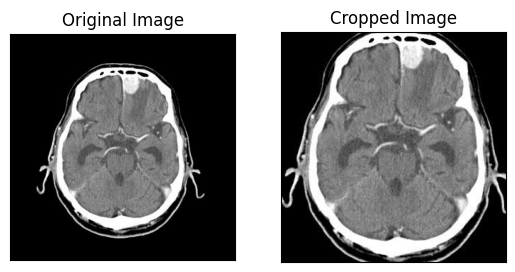

In [5]:
# ex_img = cv2.imread('/content/drive/MyDrive/brain_dataset/test/yes/m_image(25).jpg')
ex_img = cv2.imread(f'{TEST_DIR}/yes/m_image(25).jpg')
ex_new_img = crop_contour(ex_img, True)

In [6]:
# Creating training dataset
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DIR, category)
        class_num = CATEGORIES.index(category)
        for img_filename in tqdm(os.listdir(path)):
            img_path = os.path.join(path, img_filename)
            img = cv2.imread(img_path)
            # Check if img is None (image not found)
            if img is not None:
                # crop the brain and ignore the unnecessary rest part of the image
                img = crop_contour(img, plot=False)
                img_array = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                training_data.append([img_array, class_num])

    random.shuffle(training_data)

# Call the function to create training data
create_training_data()

100%|██████████████████████████████████████████████████████████████████████████████████████| 1473/1473 [00:01<00:00, 815.80it/s]


In [7]:
X_train_val = np.array([i[0] for i in training_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train_val = [i[1] for i in training_data]

In [8]:
# Creating testing dataset
testing_data = []

def create_testing_data():
    for category in CATEGORIES:
        path = os.path.join(TEST_DIR, category)
        class_num = CATEGORIES.index(category)
        for img_filename in tqdm(os.listdir(path)):
            img_path = os.path.join(path, img_filename)
            img = cv2.imread(img_path)
            # Check if img is None (image not found)
            if img is not None:
                # crop the brain and ignore the unnecessary rest part of the image
                img = crop_contour(img, plot=False)
                img_array = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                testing_data.append([img_array, class_num])

    random.shuffle(testing_data)

create_testing_data()

100%|████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 812.71it/s]


In [9]:
X_test = np.array([i[0] for i in testing_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_test = [i[1] for i in testing_data]

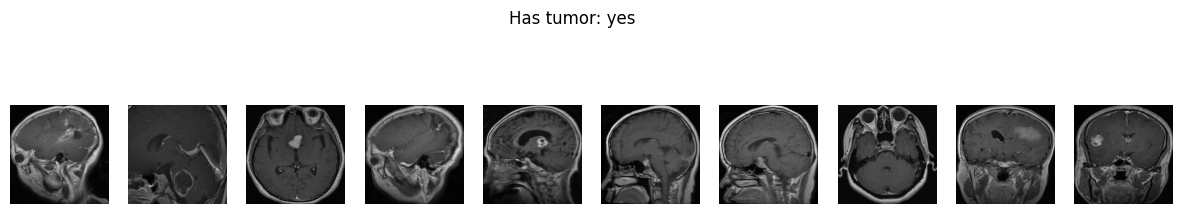

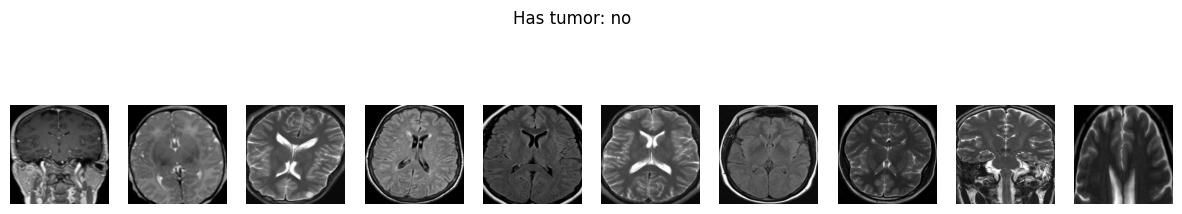

In [10]:
def plot_images_per_class(training_data):
    # Dictionary to store 10 images for each class
    class_images = {}

    # Iterate through the training data
    for data in training_data[:100]:
        img_array, class_num = data

        # Check if the class is already in the dictionary
        if class_num not in class_images:
            class_images[class_num] = [img_array]
        elif len(class_images[class_num]) < 10:
            # Append the image to the existing list for the class
            class_images[class_num].append(img_array)

    # Plot 10 images for each class
    for class_num, images in class_images.items():
        # Limit to at most 10 images
        images_to_plot = images[:10]

        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Has tumor: {CATEGORIES[class_num]}")

        for i, img_array in enumerate(images_to_plot):
            plt.subplot(1, 10, i + 1)
            plt.imshow(img_array)
            plt.axis('off')

        plt.show()

# Call the function with training data
plot_images_per_class(training_data)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.2)

In [12]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [13]:
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

X_train shape: (3282, 224, 224, 3)
Y_train shape: (3282,)
X_val shape: (821, 224, 224, 3)
Y_val shape: (821,)
X_test shape: (550, 224, 224, 3)
Y_test shape: (550,)


# CNN model

In [14]:
# Set parameters
img_width, img_height = IMG_SIZE, IMG_SIZE
input_shape = (img_width, img_height, 3)  # assuming RGB images

# Build the CNN model
model = Sequential()

# Zero-Padding: pads the border of X_input with zeroes
model.add(ZeroPadding2D((3, 3), input_shape=input_shape))

# CONV -> BN -> RELU Block applied to X
model.add(Conv2D(32, (7, 7), strides=(1, 1), name='conv0'))
model.add(BatchNormalization(axis=3, name='bn0'))
model.add(Activation('relu'))

# MAXPOOL
model.add(MaxPooling2D((4, 4), name='max_pool0'))
model.add(Dropout(0.25))

# CONV -> BN -> RELU Block applied to X
model.add(Conv2D(32, (9, 9), strides=(1, 1), name='conv1'))
model.add(BatchNormalization(axis=3, name='bn1'))
model.add(Activation('relu'))

# MAXPOOL
model.add(MaxPooling2D((4, 4), name='max_pool1'))
model.add(Dropout(0.25))

# FLATTEN X
model.add(Flatten())

# FULLYCONNECTED
model.add(Dense(200, activation='relu', name='fc0'))
model.add(BatchNormalization())
model.add(Dropout(0.33))

# FULLYCONNECTED
model.add(Dense(1, activation='sigmoid', name='fc1'))


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train,
          batch_size = 160,
          epochs = 25,
          validation_data = (X_val, y_val))

# Save the model
model.save('brain_cnn_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)       0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 224, 224, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 224, 224, 32)      128       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 56, 56, 32)        0         
                                                                 
 dropout (Dropout)           (None, 56, 56, 32)        0         
                                                        

2024-02-01 00:23:04.847469: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/25
21/21 [==============================] - 28s 1s/step - loss: 0.4416 - accuracy: 0.8556 - val_loss: 0.5559 - val_accuracy: 0.7771
Epoch 2/25
21/21 [==============================] - 24s 1s/step - loss: 0.2497 - accuracy: 0.9180 - val_loss: 0.5127 - val_accuracy: 0.6918
Epoch 3/25
21/21 [==============================] - 24s 1s/step - loss: 0.2030 - accuracy: 0.9311 - val_loss: 0.5238 - val_accuracy: 0.7150
Epoch 4/25
21/21 [==============================] - 24s 1s/step - loss: 0.1731 - accuracy: 0.9430 - val_loss: 0.6953 - val_accuracy: 0.6882
Epoch 5/25
21/21 [==============================] - 24s 1s/step - loss: 0.1522 - accuracy: 0.9467 - val_loss: 0.7183 - val_accuracy: 0.6626
Epoch 6/25
21/21 [==============================] - 24s 1s/step - loss: 0.1234 - accuracy: 0.9586 - val_loss: 1.1302 - val_accuracy: 0.6492
Epoch 7/25
21/21 [==============================] - 24s 1s/step - loss: 0.1129 - accuracy: 0.9616 - val_loss: 0.6646 - val_accuracy: 0.7357
Epoch 8/25
21/21 [==

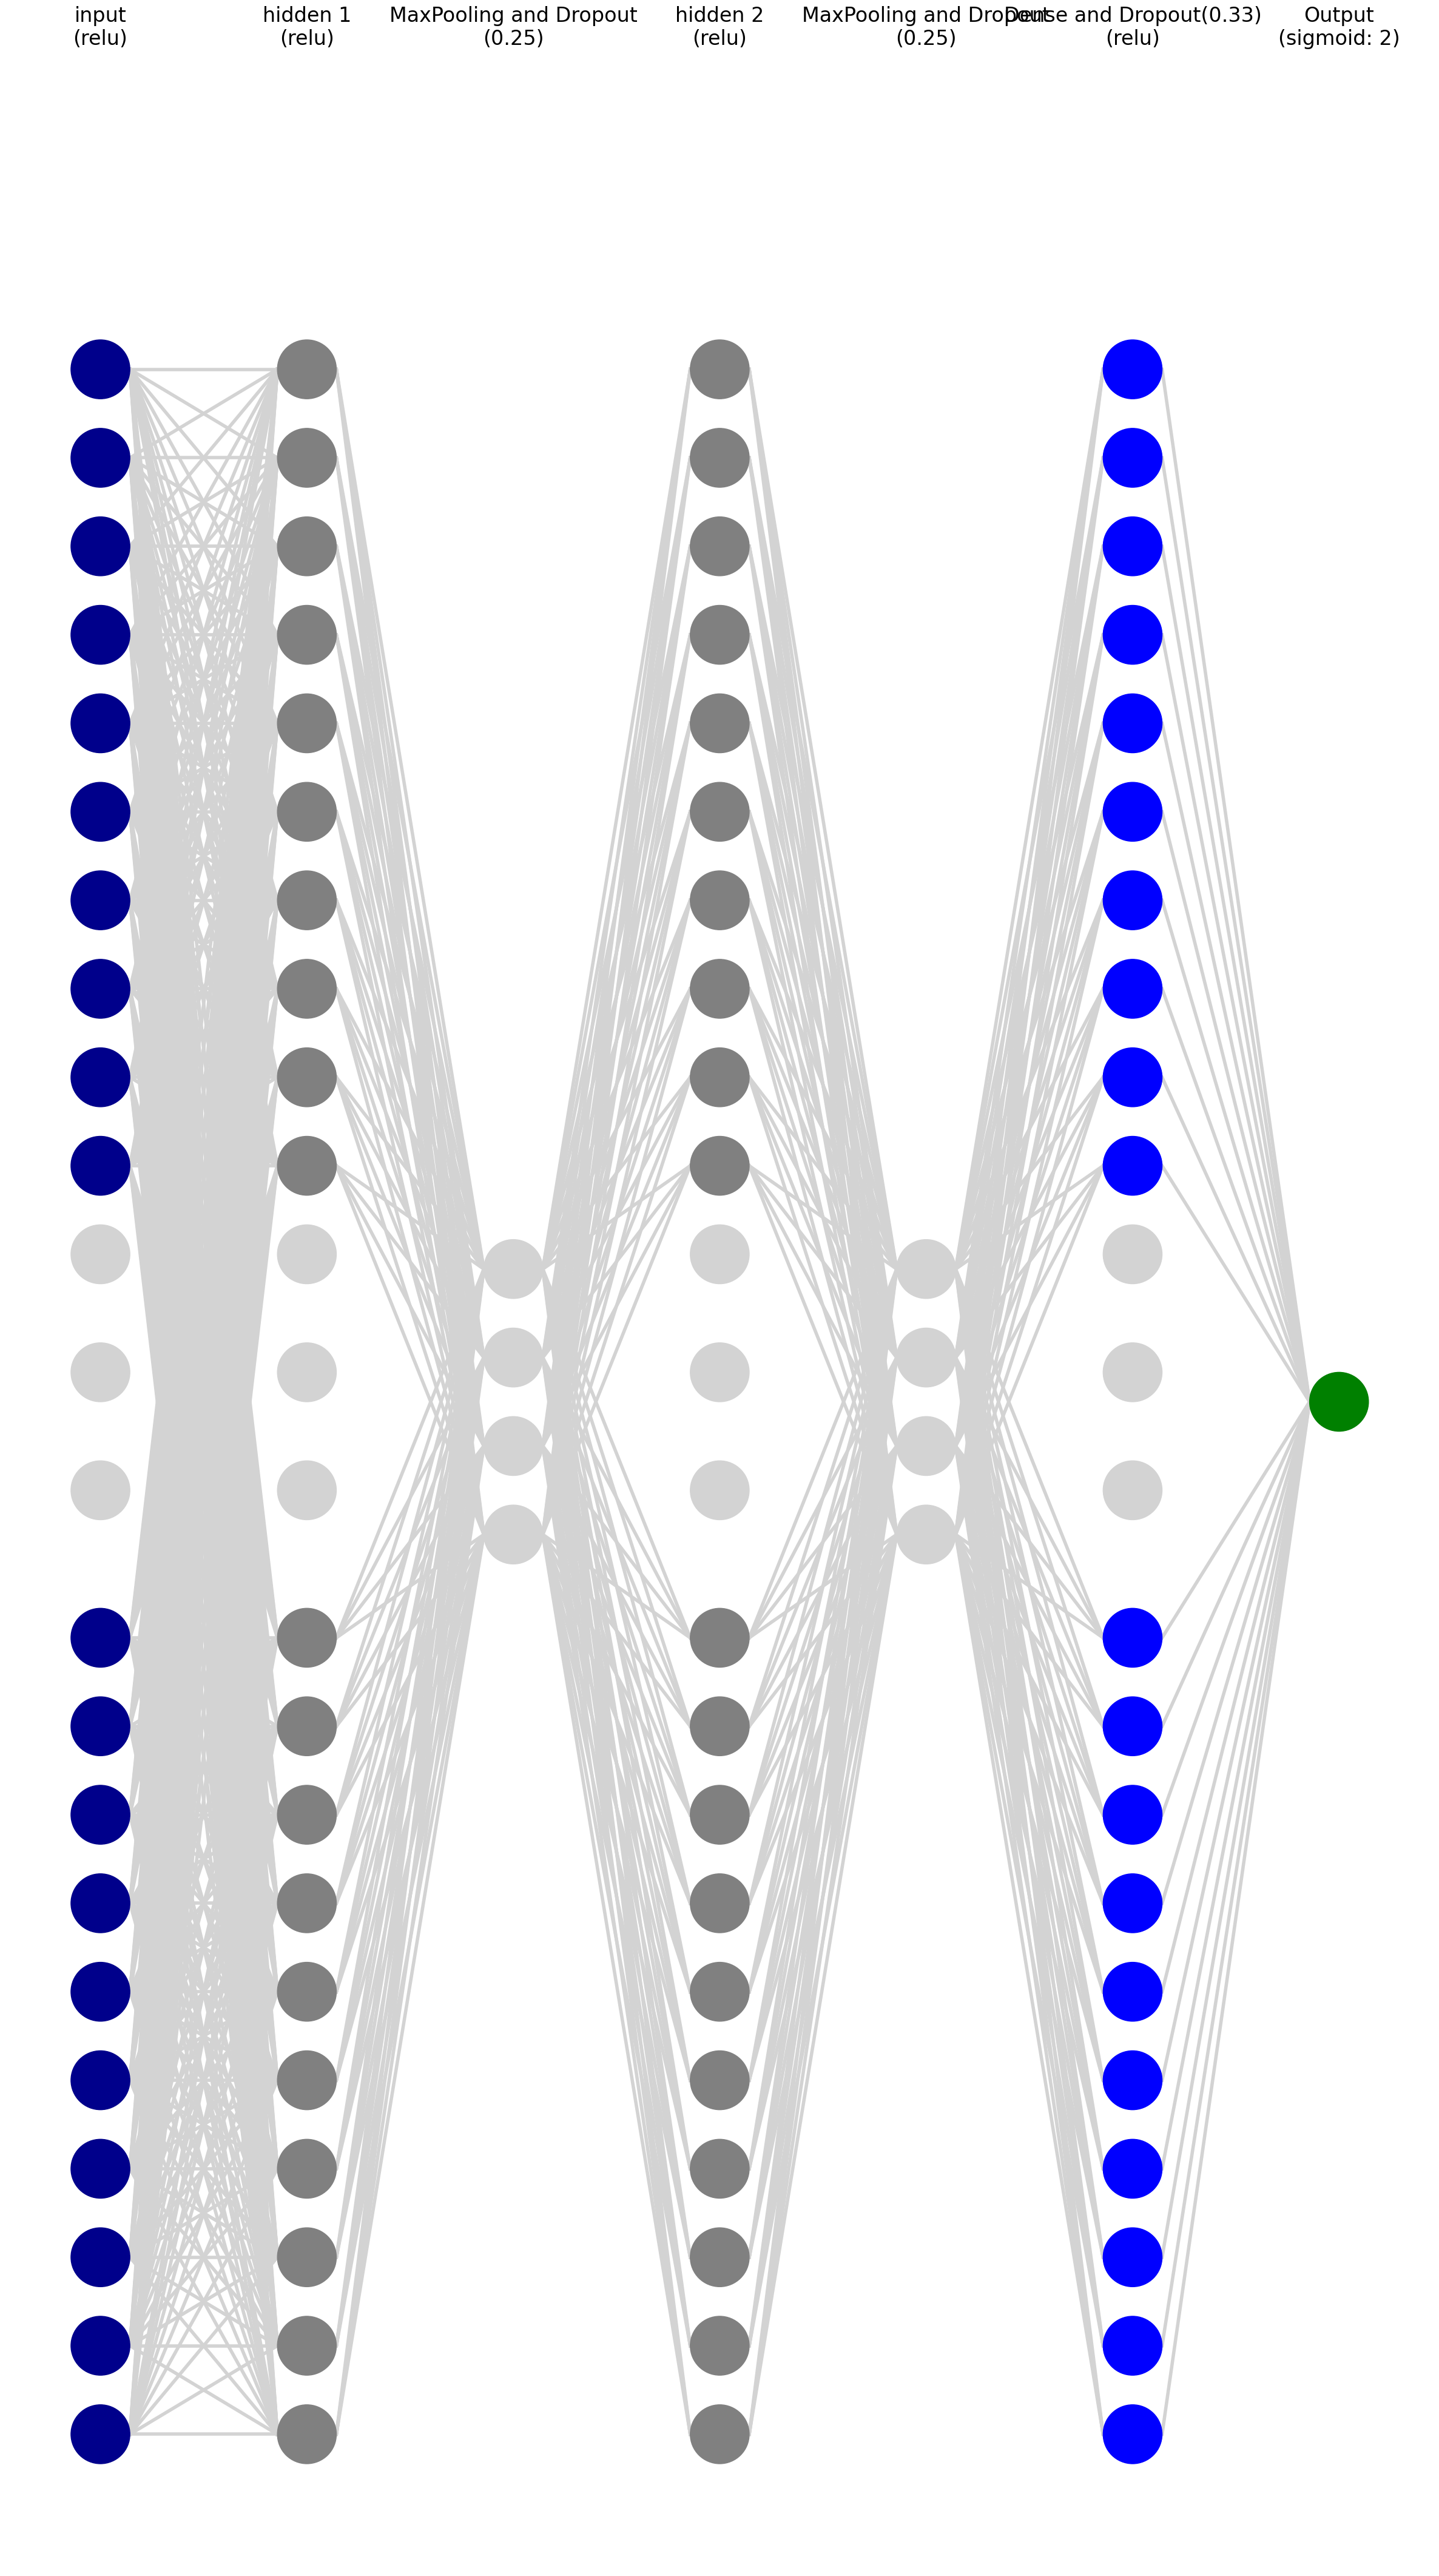

(<Figure size 10000x5000 with 1 Axes>, <Axes: >)

In [3]:
from nnv import NNV
plt.rcParams["figure.figsize"] = 100,50

layersList = [
    {"title":"input\n(relu)", "units": 50176, "color": "darkBlue"},
    {"title":"hidden 1\n(relu)", "units": 32},
    {"title":"MaxPooling and Dropout\n(0.25)", "units": 4,"color":"lightGray"},
    {"title":"hidden 2\n(relu)",  "units": 32},
    {"title":"MaxPooling and Dropout\n(0.25)", "units": 4,"color":"lightGray"},
    {"title":"Dense and Dropout(0.33)\n(relu)", "units": 200,"color":"blue"},
    {"title":"Output\n(sigmoid: 2)", "units": 1,"color": "Green"},
]

NNV(layersList, spacing_layer=5, max_num_nodes_visible=20, node_radius=1, font_size=24).render()

In [15]:
# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

18/18 [==============================] - 1s 71ms/step - loss: 0.2595 - accuracy: 0.9345
Test loss: 0.25947538018226624
Test accuracy: 0.9345454573631287


18/18 [==============================] - 1s 70ms/step
f1 score: 0.9310344827586207
recall score 0.972
precision score 0.8933823529411765


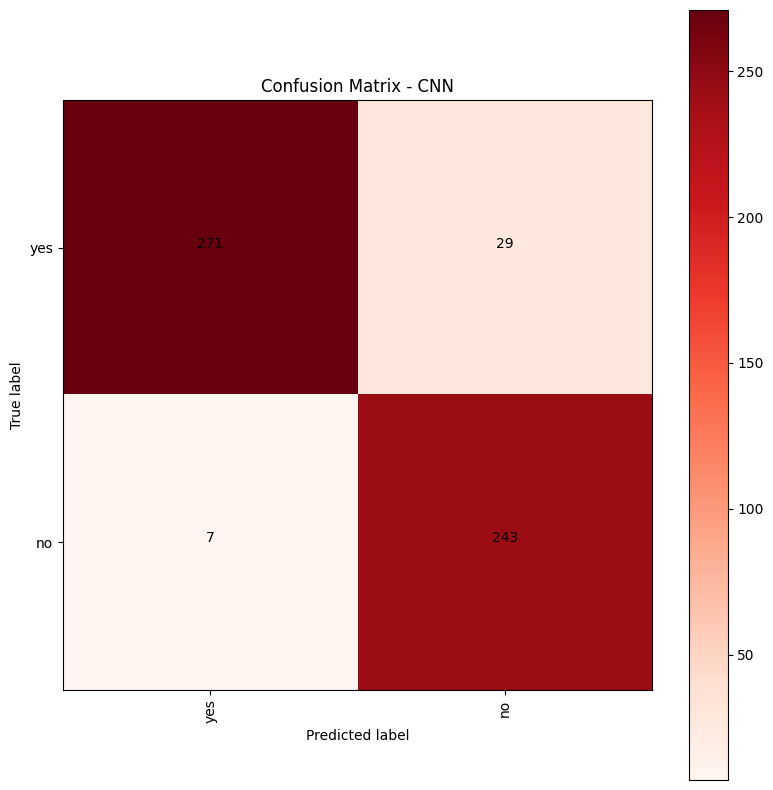

In [29]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from itertools import product

y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)

print("f1 score:", f1_score(y_test, y_pred))
print("recall score", recall_score(y_test, y_pred))
print("precision score", precision_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,8))
plt.imshow(cm,cmap=plt.cm.Reds)
plt.title('Confusion Matrix - CNN')
plt.colorbar()
plt.xticks(np.arange(len(CATEGORIES)), CATEGORIES, rotation=90)
plt.yticks(np.arange(len(CATEGORIES)), CATEGORIES)

for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
    horizontalalignment="center",
    color="white" if cm[i, j] > 500 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label');